# Libraries

In [1]:
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random 
import argparse 
from tqdm import tqdm
from math import floor
import seaborn as sns
import yfinance as yf
from bandit_library import *

# Defining Inputs

In [169]:
##INTERVAL AND TRADING PERIOD##

interval = '1d'
tau = 100
m = 30

trade_start_time = datetime.datetime(2023,5,15,17,30)

if interval == '1d':
    hist_start_time = trade_start_time - datetime.timedelta(days=tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=m)
if interval == '1w':
    hist_start_time = trade_start_time - datetime.timedelta(days=7*tau)
    trade_end_time = trade_start_time + datetime.timedelta(days=7*m)
    
hist_end_time = trade_end_time

##INTERVAL AND TRADING PERIOD##

In [170]:
##STOCKS##
tickers = ['AC.PA','ALO.PA','AI.PA','ATO.PA','CAP.PA','ORA.PA','RI.PA','TTE.PA','PINR.PA','SW.PA','SU.PA','BN.PA','PAASI.PA','PAEEM.PA','ML.PA','SK.PA']
n_assets = len(tickers)
##STOCKS##

In [171]:
data = Data(tickers)
hist_returns = data.get_data(hist_start_time,hist_end_time,interval)

Asset : ['AC.PA', 'ALO.PA', 'AI.PA', 'ATO.PA', 'CAP.PA', 'ORA.PA', 'RI.PA', 'TTE.PA', 'PINR.PA', 'SW.PA', 'SU.PA', 'BN.PA', 'PAASI.PA', 'PAEEM.PA', 'ML.PA', 'SK.PA']
[*********************100%***********************]  16 of 16 completed
start date   : 2023-02-04 17:30:00
start date   : 2023-06-14 17:30:00
time interval: 130 days, 0:00:00


# Brief Co-Dependence Analysis

Text(0.5, 1.0, 'Covariance Matrix')

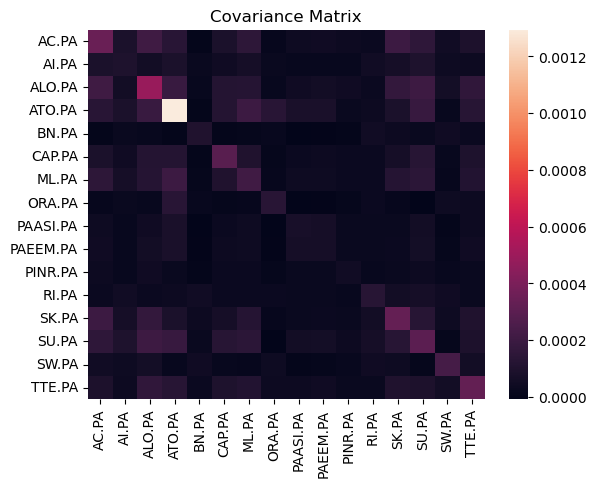

In [172]:
sns.heatmap(hist_returns.cov())
plt.title('Covariance Matrix')

Text(0.5, 1.0, 'Spearman Correlation')

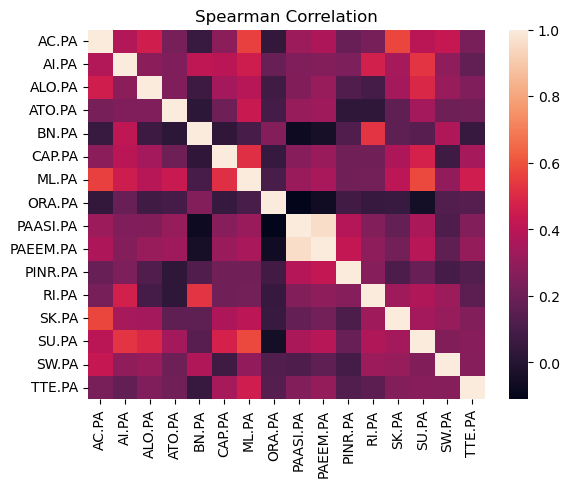

In [173]:
sns.heatmap(hist_returns.corr(method='spearman'))
plt.title('Spearman Correlation')

Let us compute the covariance matrix of our returns :

In [174]:
cov_matrix = get_cov(hist_returns)

This matrix is $\Sigma_k$ but we will need to eigen-decompose it .

We now estimate the average return $\mathbb{E}[\textbf{R}_k] \in \mathbb{R}_n $

 - $\tau$ represents the size of the training data 
 - Example : if we study an interval of 300 days, $\tau$ = 300
 - Our 'training' returns are in the interval $[k-\tau, k-1]$, hence the length is $k-1 - (k-\tau) + 1 = \tau$

NB : 
- hist_start_time = trading_start_time - $\tau$
- To ensure that the average return and the covariance matrix of assets returns $\Sigma_k$ are estimated by $(\textbf{R}_{k-\tau},..,\textbf{R}_{k-1})$

In [340]:
k=9

In [341]:
def calculate_return_and_cov(hist,k,tau,interval,trade_start_time):
    current_time_k = trade_start_time + datetime.timedelta(days=k-1)
    if interval == '1w':
        current_time_k = trade_start_time + datetime.timedelta(days=7*k)
    hist_temp = hist[(hist.index > current_time_k - datetime.timedelta(days=tau))&(hist.index < current_time_k)] #start at k-tau and end at k-1 (hist start time is shifted by -tau compared to the visible index)
    E_Rk = hist_temp.mean() 
    Sigma_k = get_cov(hist_temp)
    return(E_Rk,Sigma_k)

In [342]:
E_R,Sigma = calculate_return_and_cov(hist_returns,k,tau,interval,trade_start_time)

In [343]:
E_R

AC.PA       1.001168
AI.PA       0.996796
ALO.PA      1.014246
ATO.PA      1.009306
BN.PA       0.998016
CAP.PA      0.999597
ML.PA       0.994298
ORA.PA      1.000528
PAASI.PA    1.003607
PAEEM.PA    1.002868
PINR.PA     1.000566
RI.PA       0.998548
SK.PA       0.994155
SU.PA       1.004605
SW.PA       1.003566
TTE.PA      1.003243
dtype: float64

The next step is to decomposse of the covariance matrix :

In [344]:
Lambda, H = eigen_decomposition(Sigma)

- Lambda corresponds to $\Lambda_k$
- H corresponds to $\mathcal{H}_k$

Now we compute the renormalized similarity matrices and eigenvalues :

In [345]:
Lambda_norm, H_norm = normalization(n_assets,Eigenvalues_Sigma,EigenVectormatrix_Sigma)

- Lambda_norm corresponds to $\tilde{\Lambda_k}$
- H_norm corresponds to $\tilde{\mathcal{H}_k}$

i is the i-th portfolio among n portfolios : 

In [346]:
def get_sharpe_ratios(n_assets,Lambda,H,E_R):
    SR = []
#     SR_ki = (pd.DataFrame(H[:,i])*E_R.iloc[i])/np.sqrt(abs(Lambda[i]))
    for i in range(n_assets):
        SR.append(np.mean(np.array((pd.DataFrame(H[:,i])*E_R.iloc[i])/np.sqrt(abs(Lambda[i])))))
        
    return(SR)

We have a constructed a set of n uncorrelated portfolios with return $\textbf{H}_k^{T} \textbf{R}_k$

At time $t_k$ the return of the i-th orthogonal portfolio is estimated as $\tilde{H_{k,i}}R_{k,i}$
              and the variance with $\tilde{\lambda_{k,i}}$                  

In [347]:
E_R

AC.PA       1.001168
AI.PA       0.996796
ALO.PA      1.014246
ATO.PA      1.009306
BN.PA       0.998016
CAP.PA      0.999597
ML.PA       0.994298
ORA.PA      1.000528
PAASI.PA    1.003607
PAEEM.PA    1.002868
PINR.PA     1.000566
RI.PA       0.998548
SK.PA       0.994155
SU.PA       1.004605
SW.PA       1.003566
TTE.PA      1.003243
dtype: float64

In [348]:
SR = get_sharpe_ratios(n_assets,Lambda,H,E_R)

To select the best portfolio we use the Upper Confidence Bound policy :

In [ ]:
def James_Stein(Lambda): ##using the james stein estimator for the average return per 
    return(0)

In [349]:
def residu(k,tau,k_i):
    return(np.sqrt((2*np.log(k+tau))/tau+k_i))

In [350]:
def ucb_policy(SR,k,tau):
    L = [x + residu(k,tau,0) for x in SR]
    return(np.argmax(L))

In [351]:
ucb_policy(SR,k,tau)

10